In [2]:
import pandas as pd

In [4]:
# Relative Path
path = "data\SMSSpamCollection.csv"

df = pd.read_csv(path, sep='\t', names=['label', 'message'])
    
# Convert labels to binary by mapping the target variable
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [5]:
df.head(5)

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## 1. Class Distribution

In order to check the amount of sms' per class (ham vs spam), we show a barplot:

<Axes: >

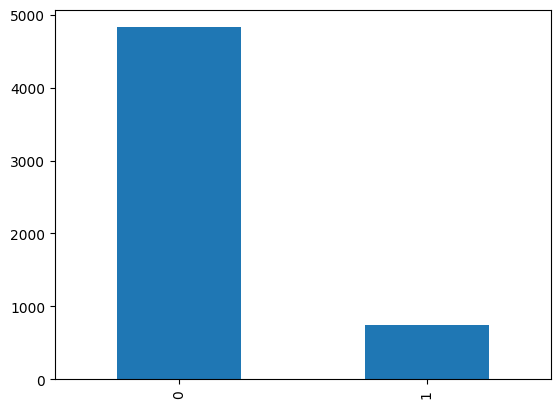

In [7]:
df['label'].value_counts().plot(kind='bar')

In [25]:
df['length'] = df['message'].apply(len)
df.groupby('label')['length'].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
1,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


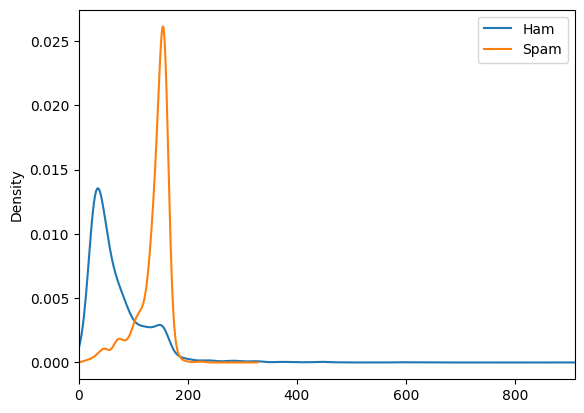

In [35]:
import matplotlib.pyplot as plt

# Get longest message
max_length = df['length'].max()

# Plot KDE distribution of both classes
df[df['label'] == 0]['length'].plot(kind='kde', label='Ham')
df[df['label'] == 1]['length'].plot(kind='kde', label='Spam')

# X-axis limits set
plt.xlim(0, max_length)
plt.legend()
plt.show()


## 2. Word Frecquency

In this section, we will analize the most common words and doing a word cloud to visualize.
In this case, we use spacy's tokenizer, which has demonstrates being better than NLTK due to its contextual tokenization, integrated preprocessing and it will be useful to integrate with TensorFlow or PyTorch during training pipeline.

IMPORTANT: Install dependency in command before: 
> python -m spacy download en_core_web_sm

In [14]:
import spacy

# Load spacy model
nlp = spacy.load("en_core_web_sm")

# tokenization function using spacy model
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc]


In [17]:
df['tokenized_text'] = df['message'].apply(spacy_tokenizer)
df['word_count'] = df['tokenized_text'].apply(len)

In [20]:
df

,label,message,tokenized_text,word_count
0,0,"Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...",24
1,0,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]",8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",31
3,0,U dun say so early hor... U c already then say...,"[U, dun, say, so, early, hor, ..., U, c, alrea...",13
4,0,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, do, n't, think, he, goes, to, usf, ,,...",15
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,"[This, is, the, 2nd, time, we, have, tried, 2,...",40
5568,0,Will ü b going to esplanade fr home?,"[Will, ü, b, going, to, esplanade, fr, home, ?]",9
5569,0,"Pity, * was in mood for that. So...any other s...","[Pity, ,, *, was, in, mood, for, that, ., So, ...",15
5570,0,The guy did some bitching but I acted like i'd...,"[The, guy, did, some, bitching, but, I, acted,...",27


In [21]:
from collections import Counter
ham_words = Counter([word for tokens in df[df['label']==0]['tokenized_text'] for word in tokens])
spam_words = Counter([word for tokens in df[df['label']==1]['tokenized_text'] for word in tokens])
print(ham_words.most_common(10))
print(spam_words.most_common(10))

[('.', 3948), ('I', 1955), ('you', 1694), ('to', 1548), (',', 1547), ('?', 1323), ('...', 1139), ('the', 1032), ('a', 981), ('i', 972)]
[('.', 1022), ('to', 611), ('!', 510), (',', 376), ('a', 360), ('£', 291), ('/', 206), ('call', 195), ('-', 191), ('you', 188)]


### 2.1. HAM Word Frequency Visualization

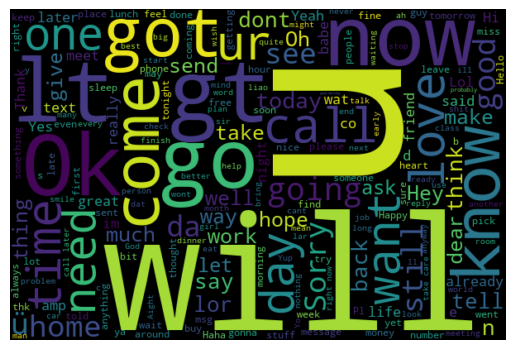

In [36]:

from wordcloud import WordCloud
ham_cloud = WordCloud(width=600, height=400).generate(" ".join(df[df['label'] == 0]['message']))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### 2.2. SPAM Word Frequency Visualization

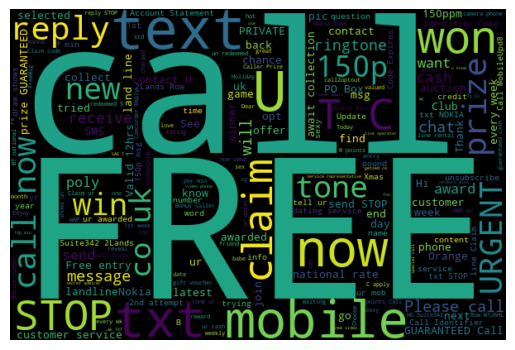

In [28]:
spam_cloud = WordCloud(width=600, height=400).generate(" ".join(df[df['label'] == 1]['message']))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3. Text Features Analysis

In [30]:
df['has_number'] = df['message'].apply(lambda x: any(char.isdigit() for char in x))
df.groupby('label')['has_number'].mean()

label
0    0.156477
1    0.947791
Name: has_number, dtype: float64

With this analysis we can confirm that spam messages has more portion of numbers (due to prices, codes, etc).

In [31]:
df['special_chars'] = df['message'].apply(lambda x: sum(1 for char in x if not char.isalnum()))
df.groupby('label')['special_chars'].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,4825.0,17.398756,15.102777,0.0,8.0,13.0,23.0,253.0
1,747.0,29.108434,7.306229,1.0,27.0,30.0,34.0,50.0


By this analysis we can confirm that ham messages have in general more portion of special characters like "$", "%", "!", among others.

In [32]:
df['uppercase_ratio'] = df['message'].apply(lambda x: sum(1 for word in x.split() if word.isupper()) / len(x.split()))
df.groupby('label')['uppercase_ratio'].mean()

label
0    0.053079
1    0.108814
Name: uppercase_ratio, dtype: float64

By this analysis, we can confirm that spam messages have more portion of uppercase per total characters. It implies that ham messages tend to be more simple and without typo correction.